In [52]:
# !pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
import warnings
from joblib import Parallel, delayed, parallel_backend, parallel_config
from pathlib import Path
import time
import multiprocessing
import pickle
import json
import os

warnings.simplefilter("ignore", FutureWarning)
%config Application.warn_ignores = FutureWarning

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 16


## Notebook Start Time

In [53]:
notebook_start_time = time.time()

## Data

In [54]:
def create_mem_map(parquet_file, data_type='train'):

    df = pd.read_parquet(parquet_file)
    scaler = MinMaxScaler()

    mem_map_dir = Path('./mem_map_files')
    mem_map_dir.mkdir(exist_ok=True)

    mem_map_file_X = mem_map_dir / f'X_{data_type}.npy'
    mem_map_file_X_scaled = mem_map_dir / f'X_{data_type}_scaled.npy'
    mem_map_file_y_2 = mem_map_dir / f'y_{data_type}_2.npy'
    mem_map_file_y_6 = mem_map_dir / f'y_{data_type}_6.npy'
    mem_map_file_y_19 = mem_map_dir / f'y_{data_type}_19.npy'

    X = df.drop(columns=['label', 'class_label', 'category_label', 'attack_label']).to_numpy()
    np.save(mem_map_file_X, X)  

    X_scaled =  scaler.fit_transform(X)
    np.save(mem_map_file_X_scaled, X_scaled) 

    encoder_2 = LabelEncoder()
    encoder_6 = LabelEncoder()
    encoder_19 = LabelEncoder()

    y_2 = encoder_2.fit_transform(df['class_label'])
    y_6 = encoder_6.fit_transform(df['category_label'])
    y_19 = encoder_19.fit_transform(df['attack_label'])

    np.save(mem_map_file_y_2, y_2)
    np.save(mem_map_file_y_6, y_6)
    np.save(mem_map_file_y_19, y_19)

    np.save(mem_map_dir / f'encoder_2_classes.npy', encoder_2.classes_)
    np.save(mem_map_dir / f'encoder_6_classes.npy', encoder_6.classes_)
    np.save(mem_map_dir / f'encoder_19_classes.npy', encoder_19.classes_)

In [55]:
mem_map_created = True

if mem_map_created is False:
    create_mem_map('./data/cic_iomt_2024_wifi_mqtt_train.parquet', data_type='train')
    create_mem_map('./data/cic_iomt_2024_wifi_mqtt_test.parquet', data_type='test')

In [56]:
mem_map_dir = Path('./mem_map_files')
X_train = np.load(mem_map_dir / 'X_train.npy', mmap_mode='r')
# X_train_scaled = np.load(mem_map_dir / 'X_train_scaled.npy', mmap_mode='r')

y_train_2 = np.load(mem_map_dir / 'y_train_2.npy', mmap_mode='r')
y_train_6 = np.load(mem_map_dir / 'y_train_6.npy', mmap_mode='r')
y_train_19 = np.load(mem_map_dir / 'y_train_19.npy', mmap_mode='r')


X_test = np.load(mem_map_dir / 'X_test.npy', mmap_mode='r')
# X_test_scaled = np.load(mem_map_dir / 'X_test_scaled.npy', mmap_mode='r')

y_test_2 = np.load(mem_map_dir / 'y_test_2.npy', mmap_mode='r')
y_test_6 = np.load(mem_map_dir / 'y_test_6.npy', mmap_mode='r')
y_test_19 = np.load(mem_map_dir / 'y_test_19.npy', mmap_mode='r')

encoder_2_classes = np.load('./mem_map_files/encoder_2_classes.npy', allow_pickle=True)
encoder_6_classes = np.load('./mem_map_files/encoder_6_classes.npy', allow_pickle=True)
encoder_19_classes = np.load('./mem_map_files/encoder_19_classes.npy', allow_pickle=True)

In [57]:
my_frac = None
# my_frac = 100000

# Use np.random.choice to randomly select indices
np.random.seed(1984)  # For reproducibility
sample_indices_train = np.random.choice(X_train.shape[0], size=my_frac, replace=False)
sample_indices_test = np.random.choice(X_test.shape[0], size=my_frac, replace=False)

# Create sample DataFrame for feature selection
if my_frac is None:
    # Use the entire dataset
    X_train_sample = X_train
    y_train_sample_2 = y_train_2
    y_train_sample_6 = y_train_6
    y_train_sample_19 = y_train_19
    X_test_sample = X_test
    y_test_sample_2 = y_test_2
    y_test_sample_6 = y_test_6
    y_test_sample_19 = y_test_19
else:
    # Use a sample of the dataset
    X_train_sample = X_train[sample_indices_train]
    y_train_sample_2 = y_train_2[sample_indices_train]
    y_train_sample_6 = y_train_6[sample_indices_train]
    y_train_sample_19 = y_train_19[sample_indices_train]
    X_test_sample = X_test[sample_indices_test]
    y_test_sample_2 = y_test_2[sample_indices_test]
    y_test_sample_6 = y_test_6[sample_indices_test]
    y_test_sample_19 = y_test_19[sample_indices_test]

In [58]:
n_features = X_train.shape[1]

## GA Code

### Classifiers
##### Defining standard features for 3 classifiers 

In [59]:
# Random forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=10,
    max_depth=15,
    n_jobs=-1,
    random_state=1984)

# AdaBoost classifier
ada_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=10,
    algorithm='SAMME.R',
    random_state=1984)

# Logistic regression classifier
lr_classifier = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    solver='lbfgs',
    max_iter=2000,
    warm_start=False,
    n_jobs=-1)

### Benchmark Function
##### Function to fit model on subset after feature reduction

In [60]:
def calculate_benchmark(
    model='rf',
    X_train_sample=None,
    X_test_sample=None,
    y_train_sample=None,
    y_test_sample=None):
    if model == 'rf':
        classifier = rf_classifier
    elif model == 'ada':
        classifier = ada_classifier
    elif model == 'lr':
        classifier = lr_classifier

    algo_start = time.time()
    classifier.fit(X_train_sample, y_train_sample)
    y_pred = classifier.predict(X_test_sample)
    algo_end = time.time()

    if np.unique(y_train_sample).size == 2:
        report = classification_report(encoder_2_classes[y_test_sample], encoder_2_classes[y_pred], output_dict=True)
    elif np.unique(y_train_sample).size == 6:
        report = classification_report(encoder_6_classes[y_test_sample], encoder_6_classes[y_pred], output_dict=True)
    else:
        report = classification_report(encoder_19_classes[y_test_sample], encoder_19_classes[y_pred], output_dict=True)

    return report, algo_end - algo_start

### Fitness Function

In [61]:
# define the fitness function for evaluating feature subsets
def fitness_function(
    individual,
    y_train_sample,
    y_test_sample,
    CLASSIFIER="rf",
    metric="accuracy"):
    # function selects the features based on the individual's genes - features with values > 0.5 are selected
    selected_features = np.where(individual == 1)[0]  # select features based on individual genes

    if len(selected_features) == 0:                   # avoid empty feature set
        return 0

    X_train_selected = X_train_sample[:, selected_features]
    X_test_selected = X_test_sample[:, selected_features]

    # in this conditions ignore part with 'lr' and 'AdaBoostClassifier'. It will be used for the full pipeline
    # but for this demonstration I use only 'rf' to make it run quicker 
    if CLASSIFIER == 'lr':
        # lr = LogisticRegression(**lr_benchmark.get_params())
        lr_classifier.fit(X_train_selected, y_train_sample)
        y_pred = lr_classifier.predict(X_test_selected)

    elif CLASSIFIER == 'ada':
        # ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=1984)
        ada_classifier.fit(X_train_selected, y_train_sample)
        y_pred = ada_classifier.predict(X_test_selected) 

    elif CLASSIFIER == 'rf':
        # rf = RandomForestClassifier(**rf_benchmark.get_params())
        rf_classifier.fit(X_train_selected, y_train_sample)
        y_pred = rf_classifier.predict(X_test_selected)

    # Calculate the chosen metric
    if metric == 'accuracy':
        score = accuracy_score(y_test_sample, y_pred)
    elif metric == 'precision':
        score = precision_score(y_test_sample, y_pred, average='weighted')
    elif metric == 'recall':
        score = recall_score(y_test_sample, y_pred, average='weighted')
    elif metric == 'f1':
        score = f1_score(y_test_sample, y_pred, average='weighted')
    else:
        raise ValueError("Invalid metric. Choose from 'accuracy', 'precision', 'recall', or 'f1'.")
    # return accuracy as the fitness score
    return score

### GA Feature Selection Function

### GA Parameters

__population_size__: Defines the number of individuals in the population, each representing a potential solution. A larger population allows for broader exploration of the solution space.

__n_generations__: Sets the maximum number of iterations the algorithm can run, allowing the population to evolve over multiple generations to find an optimal solution.

__mutation_rate__: Specifies the probability that any gene within an individual will mutate, introducing variability and helping avoid local optima.

__fitnes_threshold__: Represents the target fitness level that the algorithm aims to achieve. If reached, the algorithm will terminate early (NOT IMPLEMENTED)

__stagnation_limit__: Establishes how many generations can pass without any improvement in the best fitness score before the algorithm terminates. This helps prevent the algorithm from running unnecessarily if no progress is being made.


In [62]:
def ga_feature_selection(
    X_train_sample,
    y_train_sample,
    X_test_sample,
    y_test_sample,
    population_size=20,
    n_generations=50,
    mutation_rate=0.1,
    num_elites=4,
    CLASSIFIER="rf",
    metric="accuracy",
    silent=False,
    stagnation_limit=10):

    ###___________________START___________________###
    # Setting up objects and assertions for running main loop
    if population_size % 2 != 0:
        raise ValueError("Population size must be an even number.")

    # Get the number of features for individual length
    n_features = X_train_sample.shape[1]

    # Initialize population with random binary values (0 or 1)
    population = np.random.randint(2, size=(population_size, n_features))

    best_fitness_overall = 0
    best_individual_overall = None
    best_selected_features = 0
    termination_reason = None
    stagnation_count = 0
    ###___________________END_____________________###

    # Main loop for the genetic algorithm
    for generation in range(n_generations):
        iteration_start_loop = time.time()
        
        ### --- PROGRESS UPDATE: Loop number
        print(f"LOOP STEP: Generation {generation + 1}")
        ### ------------------------------------

        # Calculate fitness scores for the current population
        fitness_scores = np.array([fitness_function(individual, y_train_sample, y_test_sample, CLASSIFIER, metric) 
                                    for individual in population])        
        ### --- PROGRESS UPDATE: display calculated fitness scores
        #if not silent:
        #    print(f"Fitness Scores: {fitness_scores}")
        ### ----------------------------------------------------------

        # Track the best individual in the current generation
        current_best_fitness = np.max(fitness_scores)
        current_best_individual = population[np.argmax(fitness_scores)]
        current_best_num_selected_features = np.sum(current_best_individual > 0.5)
        ### --- PROGRESS UPDATE: print generation stats including number of selected features ---
        if not silent:
            print(f"Current Best Fitness = {current_best_fitness:.7f},\n" 
                  f"Current Number of Features = {current_best_num_selected_features},\n"
                  f"Current Selected Features = {current_best_individual}")
        ### -------------------------------------------------------------------------------------

        # Update overall best fitness and individual if necessary
        if current_best_fitness > best_fitness_overall:
            best_fitness_overall = current_best_fitness
            best_individual_overall = current_best_individual
            best_selected_features = current_best_num_selected_features
            stagnation_count = 0  # Reset stagnation count on improvement

        elif current_best_fitness == best_fitness_overall:
            # Choose the individual with fewer selected features if fitness is tied
            if best_selected_features > current_best_num_selected_features:
                best_selected_features = current_best_num_selected_features
                best_individual_overall = current_best_individual
                stagnation_count = 0
            else:
                stagnation_count += 1
        else:
            stagnation_count += 1  # Increment if no improvement


        ### --- PROGRESS UPDATE: print current state of best model
        if not silent:
            print(f"Overall best fitness: {best_fitness_overall:.7f},\n"
                  f"Overall Number of Features = {best_selected_features},\n"
                  f"Overall best individual: {best_individual_overall}")
        ### ----------------------------------------------------------

        # Check for stagnation
        if stagnation_count >= stagnation_limit:
            termination_reason = f"No improvement for {stagnation_limit} generations."
            print(f"Stopping early due to stagnation. Stagnation count: {stagnation_count}")
            break

        ###___________________START___________________###
        # Selection: roulette wheel selection based on fitness
        probabilities = fitness_scores / np.sum(fitness_scores)
        ### --- PROGRESS UPDATE: print probabilities
        #if not silent:
        #    print(f"Probabilities: {probabilities}")
        ### --------------------------------------------

        # Randomly selects individuals with replacement, using the probabilities array to bias the selection
        selected_indices = np.random.choice(np.arange(population_size), size=population_size, p=probabilities)
        ### --- PROGRESS UPDATE: print selected indices
        if not silent:
            print(f"Selected indices: {selected_indices}")
        ### ------------------------------------------------ 

        # Creating a new array that contains only the chosen individuals from the current generation
        selected_population = population[selected_indices]
        ###___________________END_____________________###


        ###___________________START___________________###
        # ELITISM
        elite_indices = np.argsort(fitness_scores)[-num_elites:]
        ### --- PROGRESS UPDATE: print elite indices
        if not silent:
            print(f"Elites indices: {elite_indices}")
        ### --------------------------------------------- ###

        elite_population = population[elite_indices]
        ###___________________END_____________________###


        ###___________________START___________________###
        # Crossover
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected_population[i], selected_population[i + 1]
            crossover_point = np.random.randint(1, n_features - 1)
            child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
            offspring.extend([child1, child2])

        offspring = np.array(offspring[:population_size - num_elites])
        ###___________________END_____________________###


        ###___________________START___________________### 
        # MUTATION
        for individual in offspring:
            mutation_mask = np.random.rand(n_features) < mutation_rate
            individual[mutation_mask] = 1 - individual[mutation_mask]

        # Replace the population with offspring plus elite individuals
        population = np.vstack((elite_population, offspring))
        ###___________________END_____________________###

        # iteartion time
        iteration_end_loop = time.time()
        print(f"Iteration time loop: {(iteration_end_loop - iteration_start_loop)/60:.2f} minutes")

    # Print termination reason
    print(f"Termination Reason: {termination_reason if termination_reason else 'Max generations reached'}")

    # Print best overall metric achieved
    if metric == 'accuracy':
        print(f"Best Fitness (accuracy): {best_fitness_overall:.7f}")
    elif metric == 'precision':
        print(f"Best Fitness (precision): {best_fitness_overall:.7f}")
    elif metric == 'recall':
        print(f"Best Fitness (recall): {best_fitness_overall:.7f}")
    elif metric == 'f1':
        print(f"Best Fitness (f1): {best_fitness_overall:.7f}")

    # Print selected features
    print(f"Best Individual: {best_individual_overall}")

    # Print final number of selected features
    print(f"Final Number of Overall Features = {best_selected_features},\n")
    
    # Return best fitness and individual
    return best_fitness_overall, best_individual_overall


### Random Forest

In [63]:
iteration_start_2 = time.time()

In [64]:
rf_ga_best_fitness_2, rf_ga_best_individual_2 = ga_feature_selection(
    X_train_sample=X_train_sample,
    y_train_sample=y_train_sample_2,
    X_test_sample=X_test_sample,
    y_test_sample=y_test_sample_2,
    population_size=20,
    n_generations=50,
    mutation_rate=0.1,
    num_elites=4,
    CLASSIFIER='rf',
    metric='accuracy',
    silent=False,
    stagnation_limit=10)

LOOP STEP: Generation 1
Current Best Fitness = 0.9988620,
Current Number of Features = 23,
Current Selected Features = [0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0
 1 1 0 1 0 1 1 1]
Overall best fitness: 0.9988620,
Overall Number of Features = 23,
Overall best individual: [0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0
 1 1 0 1 0 1 1 1]
Selected indices: [ 2 16  2 17 18  1  4  3  1  0  8 17 16 15 16  2  4 10  9 13]
Elites indices: [ 7 16  8  6]
Iteration time loop: 5.03 minutes
LOOP STEP: Generation 2
Current Best Fitness = 0.9989444,
Current Number of Features = 22,
Current Selected Features = [0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1
 1 1 1 1 0 0 0 1]
Overall best fitness: 0.9989444,
Overall Number of Features = 22,
Overall best individual: [0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1
 1 1 1 1 0 0 0 1]
Selected indices: [ 2 12  5  0 10  4 14 17  0  2 15 14 13 12  9 

In [65]:
iteration_end_2 = time.time()
print(f"Iteration time 2 labels: {(iteration_end_2 - iteration_start_2)/60:.2f} minutes")

Iteration time 2 labels: 114.62 minutes


In [66]:
rf_ga_features_2 = np.sum(rf_ga_best_individual_2)
selected_features_2 = np.where(rf_ga_best_individual_2 == 1)[0]
rf_ga_report_2, rf_ga_time_2 = calculate_benchmark(
    model='rf',
    X_train_sample=X_train_sample[:, selected_features_2],
    X_test_sample=X_test_sample[:, selected_features_2],
    y_train_sample=y_train_sample_2,
    y_test_sample=y_test_sample_2)
print(pd.DataFrame(rf_ga_report_2).transpose())
print(f"Number of selected features: {np.sum(rf_ga_best_individual_2 == 1)}")
print(rf_ga_time_2)

              precision    recall  f1-score       support
Attack         0.999846  0.999298  0.999572  1.576575e+06
Benign         0.971225  0.993538  0.982255  3.760700e+04
accuracy       0.999164  0.999164  0.999164  9.991637e-01
macro avg      0.985535  0.996418  0.990913  1.614182e+06
weighted avg   0.999179  0.999164  0.999168  1.614182e+06
Number of selected features: 25
11.96662425994873


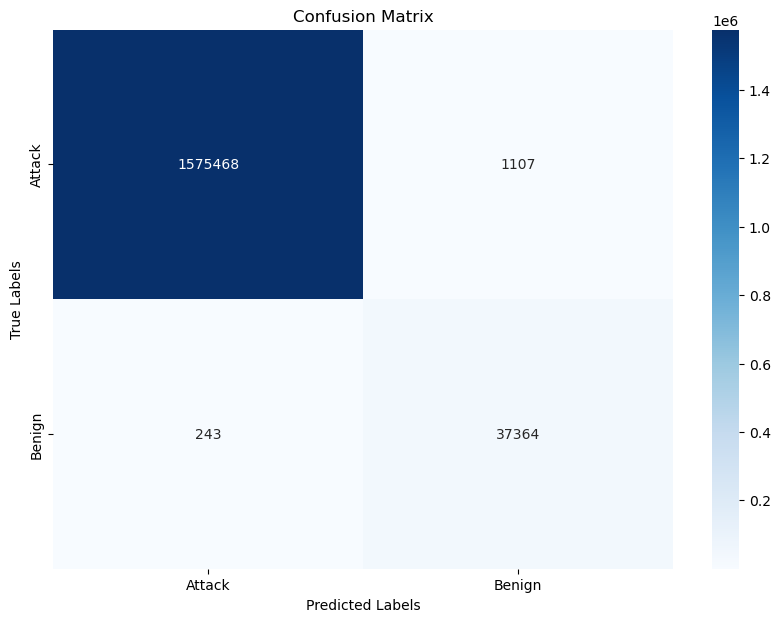

In [67]:
# calculate prediction
y_pred_rf_ga_2 = rf_classifier.predict(X_test_sample[:, selected_features_2])

# generate the confusion matrix
cm_rf_ga_2 = confusion_matrix(y_test_sample_2, y_pred_rf_ga_2)

# get names for confusion matrix
df_2 = pd.DataFrame(rf_ga_report_2)
column_names_2 = df_2.columns.tolist()[0:2]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_ga_2,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_2,
            yticklabels=column_names_2)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 6 Classes

In [68]:
iteration_start_6 = time.time()

In [69]:
rf_ga_best_fitness_6, rf_ga_best_individual_6 = ga_feature_selection(
    X_train_sample=X_train_sample,
    y_train_sample=y_train_sample_6,
    X_test_sample=X_test_sample,
    y_test_sample=y_test_sample_6,
    population_size=20,
    n_generations=50,
    mutation_rate=0.1,
    num_elites=4,
    CLASSIFIER='rf',
    metric='accuracy',
    silent=False,
    stagnation_limit=10)

LOOP STEP: Generation 1
Current Best Fitness = 0.9986712,
Current Number of Features = 29,
Current Selected Features = [0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 1 1]
Overall best fitness: 0.9986712,
Overall Number of Features = 29,
Overall best individual: [0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 1 1]
Selected indices: [17  9 17  6 13 12  9  6 14 16  3  8  9 14 12  6  3 12  0  6]
Elites indices: [ 7  9 19 17]
Iteration time loop: 4.83 minutes
LOOP STEP: Generation 2
Current Best Fitness = 0.9986712,
Current Number of Features = 29,
Current Selected Features = [0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 1 1]
Overall best fitness: 0.9986712,
Overall Number of Features = 29,
Overall best individual: [0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 1 1]
Selected indices: [ 2 13  6 13 14  0 17  3  2  7 11 13  4 15 11 

In [70]:
iteration_end_6 = time.time()
print(f"Iteration time 6 labels: {(iteration_end_6 - iteration_start_6)/60:.2f} minutes")

Iteration time 6 labels: 108.77 minutes


In [71]:
rf_ga_features_6 = np.sum(rf_ga_best_individual_6)
selected_features_6 = np.where(rf_ga_best_individual_6 == 1)[0]
rf_ga_report_6, rf_ga_time_6 = calculate_benchmark(
    model='rf',
    X_train_sample=X_train_sample[:, selected_features_6],
    X_test_sample=X_test_sample[:, selected_features_6],
    y_train_sample=y_train_sample_6,
    y_test_sample=y_test_sample_6)
print(pd.DataFrame(rf_ga_report_6).transpose())
print(f"Number of selected features: {np.sum(rf_ga_best_individual_6 == 1)}")
print(rf_ga_time_6)

              precision    recall  f1-score       support
Benign         0.964521  0.999043  0.981479  3.760700e+04
DDos           0.999819  0.999964  0.999892  1.066764e+06
Dos            0.999914  0.999537  0.999725  4.166760e+05
MQTT           0.999874  0.992780  0.996314  6.371500e+04
Recon          0.993945  0.972720  0.983218  2.767600e+04
Spoofing       0.913375  0.755734  0.827110  1.744000e+03
accuracy       0.998818  0.998818  0.998818  9.988180e-01
macro avg      0.978575  0.953296  0.964623  1.614182e+06
weighted avg   0.998829  0.998818  0.998806  1.614182e+06
Number of selected features: 27
12.620483636856079


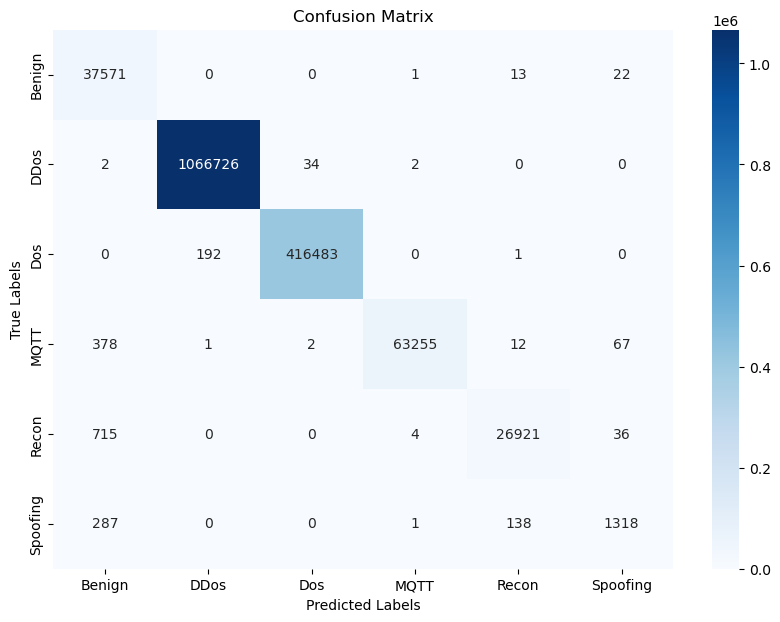

In [72]:
# calculate prediction
y_pred_rf_ga_6 = rf_classifier.predict(X_test_sample[:, selected_features_6])

# generate the confusion matrix
cm_rf_ga_6 = confusion_matrix(y_test_sample_6, y_pred_rf_ga_6)

# get names for confusion matrix
df_6 = pd.DataFrame(rf_ga_report_6)
column_names_6 = df_6.columns.tolist()[0:6]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_ga_6,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_6,
            yticklabels=column_names_6)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 19 Classes

In [73]:
iteration_start_19 = time.time()

In [74]:
rf_ga_best_fitness_19, rf_ga_best_individual_19 = ga_feature_selection(
    X_train_sample=X_train_sample,
    y_train_sample=y_train_sample_19,
    X_test_sample=X_test_sample,
    y_test_sample=y_test_sample_19,
    population_size=20,
    n_generations=50,
    mutation_rate=0.1,
    num_elites=4,
    CLASSIFIER='rf',
    metric='accuracy',
    silent=False,
    stagnation_limit=10)

LOOP STEP: Generation 1
Current Best Fitness = 0.9962860,
Current Number of Features = 22,
Current Selected Features = [0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 0]
Overall best fitness: 0.9962860,
Overall Number of Features = 22,
Overall best individual: [0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 0]
Selected indices: [19 14 15  4 19 11  6 16 10  5  4 12  8 18 10 16 17  1  8 11]
Elites indices: [19  7  4  1]
Iteration time loop: 4.69 minutes
LOOP STEP: Generation 2
Current Best Fitness = 0.9962860,
Current Number of Features = 22,
Current Selected Features = [0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 0]
Overall best fitness: 0.9962860,
Overall Number of Features = 22,
Overall best individual: [0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 0]
Selected indices: [16 18 14 12  8  3 16  6  2 16  0  4  2  2 12 

In [75]:
iteration_end_19 = time.time()
print(f"Iteration time 19 labels: {(iteration_end_19 - iteration_start_19)/60:.2f} minutes")

Iteration time 19 labels: 74.94 minutes


In [76]:
rf_ga_features_19 = np.sum(rf_ga_best_individual_19)
selected_features_19 = np.where(rf_ga_best_individual_19 == 1)[0]
rf_ga_report_19, rf_ga_time_19 = calculate_benchmark(
    model='rf',
    X_train_sample=X_train_sample[:, selected_features_19],
    X_test_sample=X_test_sample[:, selected_features_19],
    y_train_sample=y_train_sample_19, 
    y_test_sample=y_test_sample_19)
print(pd.DataFrame(rf_ga_report_19).transpose())
print(f"Number of selected features: {np.sum(rf_ga_best_individual_19 == 1)}")
print(rf_ga_time_19)

                    precision    recall  f1-score       support
ARP_spoofing         0.915636  0.721904  0.807310  1.744000e+03
Benign               0.955474  0.998564  0.976544  3.760700e+04
DDoS_ICMP            0.999503  0.999949  0.999726  3.496990e+05
DDoS_SYN             0.999849  0.998689  0.999269  1.723970e+05
DDoS_TCP             0.999595  0.999896  0.999745  1.825980e+05
DDoS_UDP             0.999368  0.999624  0.999496  3.620700e+05
DDoS_connect_flood   0.999952  0.999928  0.999940  4.191600e+04
DDoS_publish_flood   0.999282  0.992514  0.995887  8.416000e+03
DoS_ICMP             0.999624  0.999126  0.999375  9.843200e+04
DoS_SYN              0.999848  0.999838  0.999843  9.859500e+04
DoS_TCP              0.999842  0.999817  0.999829  8.209600e+04
DoS_UDP              0.999709  0.999237  0.999473  1.375530e+05
DoS_connect_flood    0.998085  0.998722  0.998404  3.131000e+03
DoS_publish_flood    0.993110  0.999882  0.996485  8.505000e+03
Malformed_date       1.000000  0.718947 

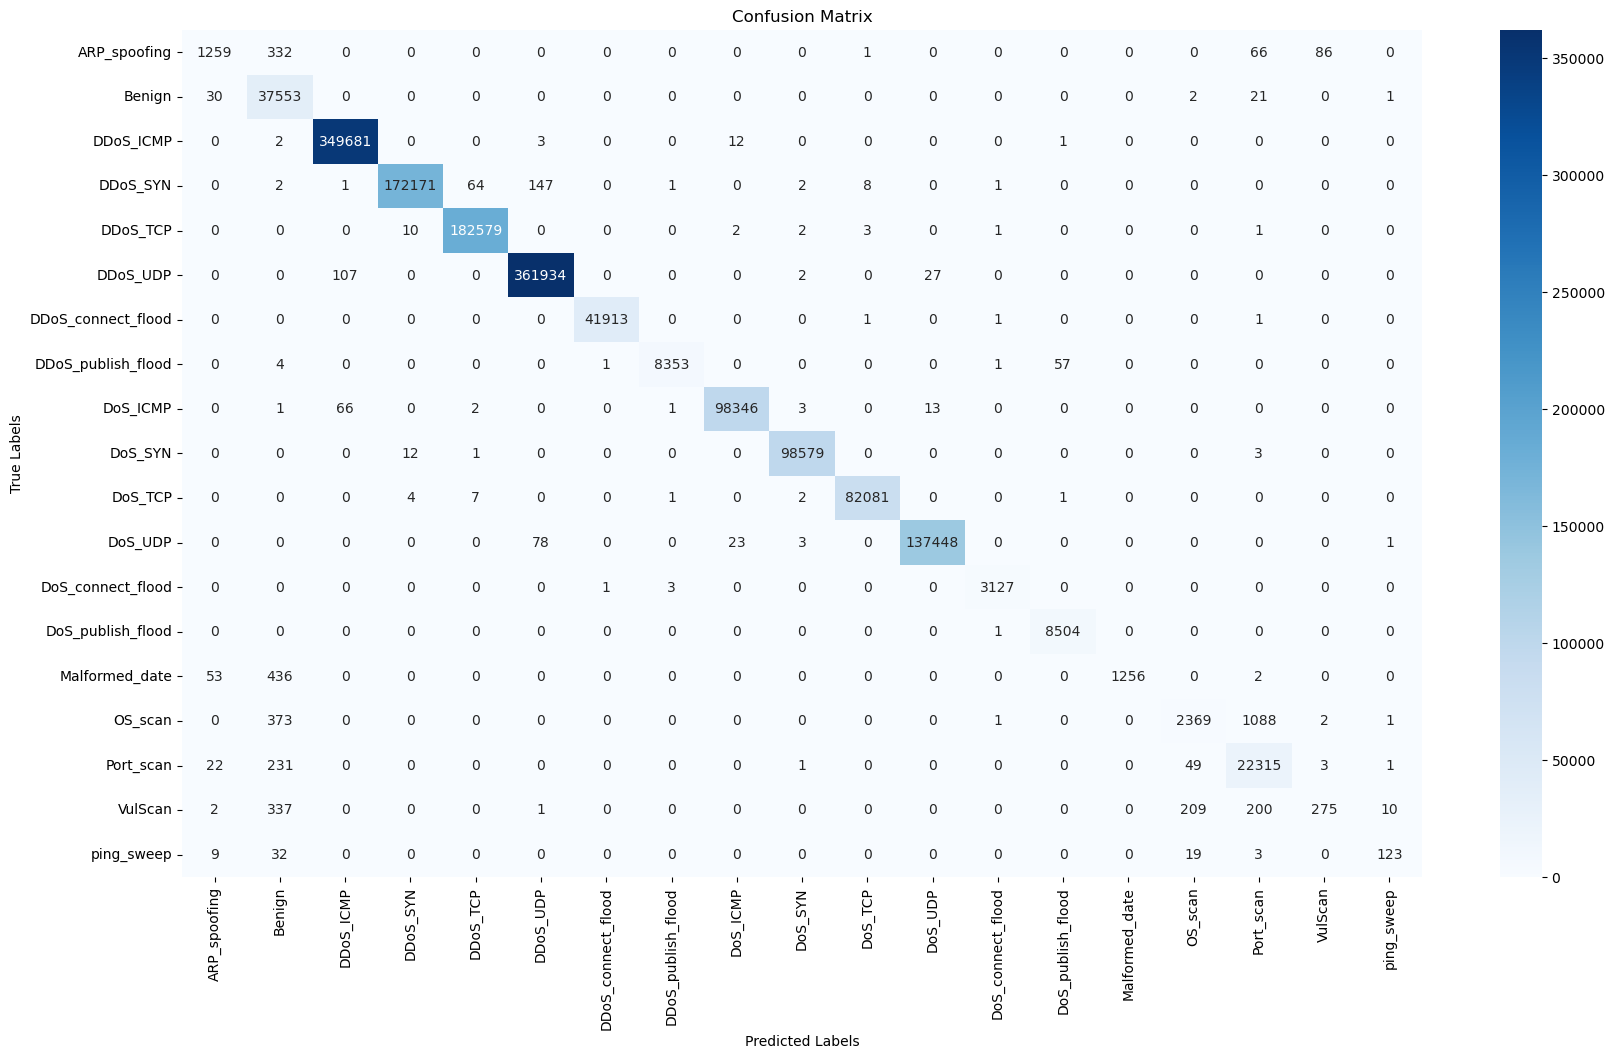

In [77]:
# calculate prediction
y_pred_rf_ga_19 = rf_classifier.predict(X_test_sample[:, selected_features_19])

# generate the confusion matrix
cm_rf_ga_19 = confusion_matrix(y_test_sample_19, y_pred_rf_ga_19)

# get names for confusion matrix
df_19 = pd.DataFrame(rf_ga_report_19)
column_names_19 = df_19.columns.tolist()[0:19]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(20, 11))
sns.heatmap(cm_rf_ga_19,
            annot=True, fmt='d',
            cmap='Blues',
            xticklabels=column_names_19,
            yticklabels=column_names_19)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Results

In [78]:
results_folder='results_data_ga'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [79]:
data_to_save = {
    'rf_ga_report_2': rf_ga_report_2,
    'rf_ga_time_2': rf_ga_time_2,
    'rf_ga_features_2': rf_ga_features_2,
    'rf_ga_best_pos_2': rf_ga_best_individual_2,
    'rf_ga_report_6': rf_ga_report_6,
    'rf_ga_time_6': rf_ga_time_6,
    'rf_ga_features_6': rf_ga_features_6,
    'rf_ga_best_pos_6': rf_ga_best_individual_6,
    'rf_ga_report_19': rf_ga_report_19,
    'rf_ga_time_19': rf_ga_time_19,
    'rf_ga_features_19': rf_ga_features_19,
    'rf_ga_best_pos_19': rf_ga_best_individual_19
}

In [80]:
for name, data in data_to_save.items():
    file_path = os.path.join(results_folder, f'{name}.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

In [81]:
for key in data_to_save:
    if isinstance(data_to_save[key], np.integer):
        data_to_save[key] = int(data_to_save[key])
    elif isinstance(data_to_save[key], np.ndarray):
        data_to_save[key] = data_to_save[key].tolist()

for name, data in data_to_save.items():
    file_path = os.path.join(results_folder, f'{name}.json')
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

In [82]:
notebook_end_time = time.time()
print(f"Notebook Duration: {(notebook_end_time - notebook_start_time) / 60} minutes")

Notebook Duration: 301.85230077107747 minutes
